# Levy Processes and Applications
## Stochastic Volatility Model: NIG-CIR
### Date: 26/10/2024
### Group Components: 
- Tornike Kikacheishvili - 60762
- Simone Fabbri - 63292
- Pouria Baharizadeh - 63263
- Ibrahim Bamba - 63254
- Rodrigo Orozco Perez - 60348

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
import statistics

np.random.seed(42)  # Set seed for reproducibility

## 1. Simulation of the process

### 1.1 Simulation of Brownian motion

In [16]:
def brownian_motion(time_array):
    """
    Generate a Brownian motion (Wiener process) given a time array.
    
    Parameters:
        time_array (numpy array): Array of time points for which to generate the Brownian motion.
    
    Returns:
        numpy array: Array representing the Brownian motion process at each time in time_array.
    """
    # Calculate time increments
    dt = np.diff(time_array)  # time intervals
    dt = np.insert(dt, 0, 0)  # ensure first element is 0
    # Generate random increments (normal distribution with mean 0 and variance dt)
    dW = np.sqrt(dt) * np.random.normal(0, 1, len(time_array))
    # Calculate Brownian motion as cumulative sum of increments
    W = np.cumsum(dW)
    return W

#### Test function

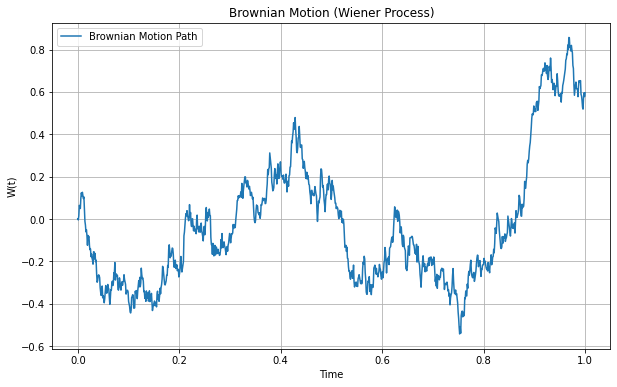

In [17]:
# Create a time array with 1000 equally spaced steps from 0 to 1
time_array = np.linspace(0, 1, 1000)
# Generate Brownian motion for the given time array
brownian_path = brownian_motion(time_array)
# Plot the Brownian motion path
plt.figure(figsize=(10, 6))
plt.plot(time_array, brownian_path, label="Brownian Motion Path")
plt.title("Brownian Motion (Wiener Process)")
plt.xlabel("Time")
plt.ylabel("W(t)")
plt.legend()
plt.grid(True)
plt.show()

### 1.2 Simulation of the CIR process

In [18]:
def get_CIR(kappa, eta, lambda_, y0, T, N):
    """
    Generates a Cox-Ingersoll-Ross (CIR) process.

    Parameters:
    kappa (float): Mean reversion speed.
    eta (float): Long-term mean.
    lambda_ (float): Volatility.
    y0 (float): Initial value.
    T (float): Time horizon.
    N (int): Number of time steps.

    Returns:
    numpy.ndarray: Simulated CIR process.
    """
    # Time step size
    dt = T / N
    # Time grid
    t = np.linspace(0, T, N)
    # Initialize the process
    y = np.zeros(N)
    y[0] = y0
    # Simulate the CIR process
    for i in range(1, N):
        vn = np.random.randn()  # Standard normal random variable
        y[i] = y[i - 1] + kappa * (eta - y[i - 1]) * dt + lambda_ * np.sqrt(y[i - 1]) * np.sqrt(dt) * vn
        # Ensure non-negativity
        y[i] = max(y[i], 0)
    return y

def get_ICIR(y):
    """
    Integrates a CIR process by computing the cumulative sum up to each point.

    Parameters:
    y (numpy.ndarray): CIR process vector.

    Returns:
    numpy.ndarray: Integrated CIR process (cumulative sum).
    """
    # Compute cumulative sum (integrated process)
    integrated_y = np.cumsum(y)
    return integrated_y


#### Test function

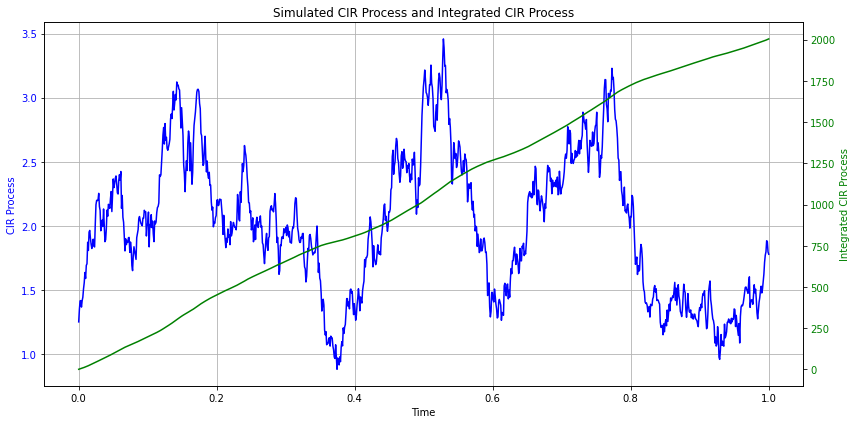

In [19]:
# Test parameters
kappa = 5     # Mean reversion speed
eta = 1       # Long-term mean
lambda_ = 2   # Volatility
y0 = 1.25     # Initial value
T = 1.0       # Time horizon
N = 1000      # Number of time steps
# Generate the CIR process
y = get_CIR(kappa, eta, lambda_, y0, T, N)
# Integrate the CIR process
integrated_y = get_ICIR(y)
# Time grid
t = np.linspace(0, T, N)
# Plot CIR and Integrated CIR on separate y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot CIR process on the primary y-axis
ax1.plot(t, y, label="CIR Process", color="blue")
ax1.set_xlabel("Time")
ax1.set_ylabel("CIR Process", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.grid(True)
# Plot Integrated CIR on the secondary y-axis
ax2 = ax1.twinx()  # Create a secondary y-axis sharing the same x-axis
ax2.plot(t, integrated_y, label="Integrated CIR Process", color="green")
ax2.set_ylabel("Integrated CIR Process", color="green")
ax2.tick_params(axis="y", labelcolor="green")
# Title and show plot
plt.title("Simulated CIR Process and Integrated CIR Process")
fig.tight_layout()
plt.show()

### 1.3 Simulation of the Inverse Gaussian Process

In [20]:
def get_number_IG(a, b): 
    """
    Generates a random number from an inverse Gaussian (IG) distribution with parameters a and b.

    Parameters:
    a (float): The mean of the IG distribution.
    b (float): The shape parameter of the IG distribution.

    Returns:
    float: A random number from the inverse Gaussian distribution.
    """
    # Step 1: Generate a standard normal random variable
    z = np.random.randn()
    # Step 2: Compute y = z^2
    y = z ** 2
    # Step 3: Compute the potential IG values
    x = (a / b) + (y / (2 * b * b)) - np.sqrt((4 * a * b * y) + (y * y)) / (2 * b * b)
    # Step 4: Generate a uniform random variable
    u = np.random.rand()
    # Step 5: Return x or x_alt based on the condition
    if(a==0):
        return 0
    return x if u <= a / (a + x * b) else (a * a) / (b * b * x)  # Alternative value based on inverse relationship

def get_IG(t, a, b):
    """
    Simulates an Inverse Gaussian (IG) process over non-equidistant time steps.

    Parameters:
    t (array-like): Array of time steps (not necessarily equally spaced).
    a (float): Mean parameter for the IG distribution.
    b (float): Shape parameter for the IG distribution.

    Returns:
    numpy.ndarray: The IG process values at each time step in t.
    """
    # Initialize the IG process array
    IG_process = np.zeros(len(t))
    # Simulate IG increments for each time step
    for i in range(1, len(t)):
        delta_t = t[i] - t[i - 1]
        IG_increment = get_number_IG(a * delta_t, b)
        IG_process[i] = IG_process[i - 1] + IG_increment  # Cumulative sum for process
    return IG_process

def get_IG_CIR(kappa, eta, lambda_, y0, T, N, a, b):
    """
    Simulates an Inverse Gaussian (IG) process time changed using a CIR process.

    Parameters:
    kappa (float): Mean reversion speed of the CIR.
    eta (float): Long-term mean of the CIR.
    lambda_ (float): Volatility of the CIR.
    y0 (float): Initial value of the CIR.
    T (float): Time horizon of the CIR.
    N (int): Number of time steps of the CIR.
    a (float): Mean parameter for the IG distribution.
    b (float): Shape parameter for the IG distribution.

    Returns:
    numpy.ndarray: The IG process values at each time step in t.
    """
    # Generate the CIR process
    time = get_ICIR(get_CIR(kappa, eta, lambda_, y0, T, N))*T/N
    return time, get_IG(time, a, b)



#### Test function

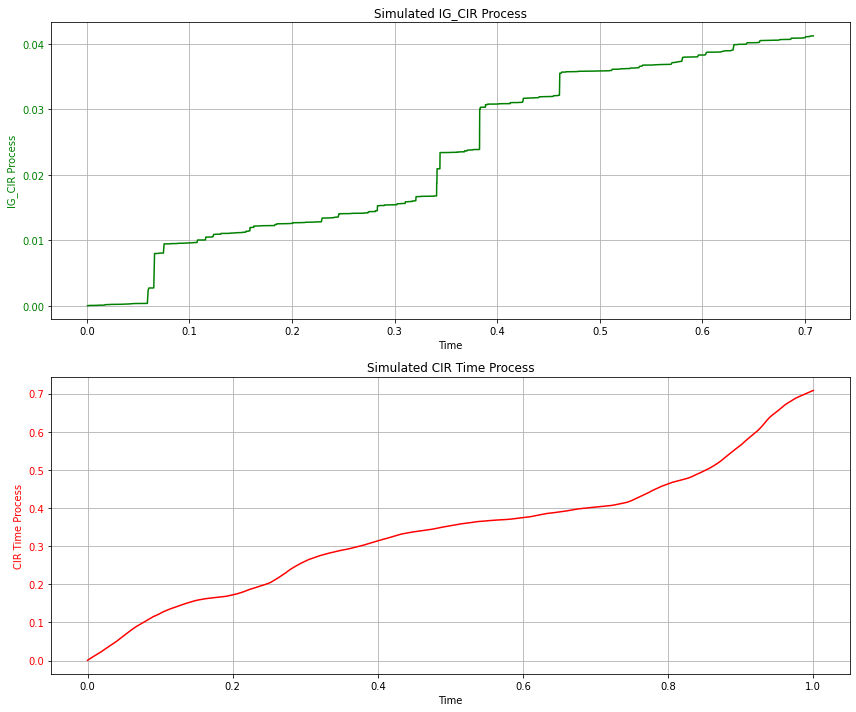

In [21]:
# Test parameters CIR
kappa = 5     # Mean reversion speed
eta = 1       # Long-term mean
lambda_ = 2   # Volatility
y0 = 1.25     # Initial value
T = 1.0       # Time horizon
N = 2000      # Number of time steps
# Test parameters for the Inverse Gaussian (IG) process
a = 1  # Mean parameter
b = 20  # Shape parameter
# Generate the IG process using CIR time array
t = np.linspace(0, T, N)
IG_process = get_IG(t, a, b)
time_ICIR, IG_CIR_process = get_IG_CIR(kappa, eta, lambda_, y0, T, N, a, b)
# Plot IG and IG_CIR on separate y-axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))  # Create a 2x1 grid of subplots
# Plot IG_CIR process on the first subplot
ax1.plot(time_ICIR, IG_CIR_process, label="IG_CIR Process", color="green")
ax1.set_xlabel("Time")
ax1.set_ylabel("IG_CIR Process", color="green")
ax1.tick_params(axis="y", labelcolor="green")
ax1.grid(True)
ax1.set_title("Simulated IG_CIR Process")
# Plot CIR Time process on the second subplot
ax2.plot(t, time_ICIR, label="CIR Time Process", color="red")
ax2.set_xlabel("Time")
ax2.set_ylabel("CIR Time Process", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.grid(True)
ax2.set_title("Simulated CIR Time Process")
# Adjust layout to avoid overlap and show the plot
fig.tight_layout()
plt.show()

### 1.4 Simulation of the Normal Inverse Gaussian Process

In [22]:
def get_NIG(t, alpha, beta, delta):
    """
    Generate a Normal Inverse Gaussian (NIG) process.
    
    Parameters:
        t: time process of the underlying Inverse Gaussian process.
        alpha (float): Tail heaviness parameter for the NIG process.
        beta (float): Asymmetry parameter for the NIG process.
        delta (float): Scale parameter for the NIG process.
    
    Returns:
        numpy array: Array representing the NIG process at each point in the inverse Gaussian process.
    """
    # Generate the underlying Inverse Gaussian time process
    a = 1
    b = delta * np.sqrt(alpha*alpha - beta*beta)
    inv_gaussian_process = get_IG(t, a, b)
    # Generate Brownian motion for the time array defined by the inverse Gaussian process
    W_G = brownian_motion(inv_gaussian_process)
    # Compute the NIG process
    X_t = beta * delta * delta * inv_gaussian_process + delta * W_G
    return X_t


def get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta):
    """
    Generate a Normal Inverse Gaussian (NIG) process.
    
    Parameters:
        kappa (float): Mean reversion speed of the CIR.
        eta (float): Long-term mean of the CIR.
        lambda_ (float): Volatility of the CIR.
        y0 (float): Initial value of the CIR.
        T (float): Time horizon of the CIR.
        N (int): Number of time steps of the CIR.
        alpha (float): Tail heaviness parameter for the NIG process.
        beta (float): Asymmetry parameter for the NIG process.
        delta (float): Scale parameter for the NIG process.
    
    Returns:
        numpy array: Array representing the NIG process at each point in the inverse Gaussian process.
    """
    # Generate the CIR process (time process of the underlying Inverse Gaussian Process)
    time_CIR = get_ICIR(get_CIR(kappa, eta, lambda_, y0, T, N))*T/N
    return time_CIR, get_NIG(time_CIR, alpha, beta, delta)


#### Test function (using Schoutens' book parameters)

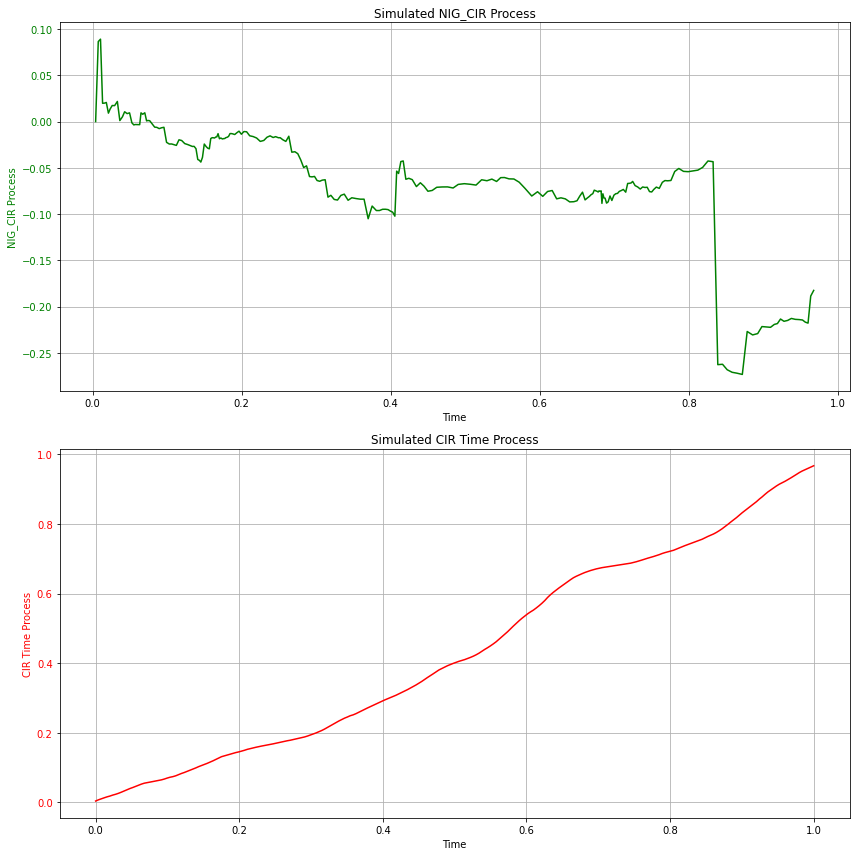

In [23]:
# Test parameters CIR
kappa = 0.5391     # Mean reversion speed
eta = 1.5746       # Long-term mean
lambda_ = 1.8772   # Volatility
y0 = 1     # Initial value
T = 1.0       # Time horizon
N = 252      # Number of time steps
# Test parameters for the Inverse Gaussian (IG) process
alpha = 18.4815 #Tail heaviness parameter for the NIG process.
beta = -4.8412 #Asymmetry parameter for the NIG process.
delta = 0.4685 #Scale parameter for the NIG process.
# Generate the IG process using CIR time array
t = np.linspace(0, T, N)
time_ICIR, NIG_CIR_process = get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta)
NIG_process = get_NIG(t, alpha, beta, delta)
# Plot NIG and IRCIR on separate y-axes
fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(12, 12))  # Create a 3x1 grid of subplots
# Plot NIG_CIR process on the second subplot
ax2.plot(time_ICIR, NIG_CIR_process, label="NIG_CIR Process", color="green")
ax2.set_xlabel("Time")
ax2.set_ylabel("NIG_CIR Process", color="green")
ax2.tick_params(axis="y", labelcolor="green")
ax2.grid(True)
ax2.set_title("Simulated NIG_CIR Process")
# Plot CIR Time process on the third subplot
ax3.plot(t, time_ICIR, label="CIR Time Process", color="red")
ax3.set_xlabel("Time")
ax3.set_ylabel("CIR Time Process", color="red")
ax3.tick_params(axis="y", labelcolor="red")
ax3.grid(True)
ax3.set_title("Simulated CIR Time Process")
# Adjust layout to avoid overlap and show the plot
fig.tight_layout()
plt.show()

### 1.5 Simulation of the Levy Process

Calculation of the risk-neutral correction

In [24]:
def risk_neutral (r, q, u, t, kappa, eta, lambda_, y0):
    # Calculate exp_iuYt_y0
    # new u (suggested by professor)
    #u = -1*delta*(cmath.sqrt(alpha*alpha-(beta+1)**2) - cmath.sqrt(alpha*alpha-beta*beta))
    # Calculate gamma (γ)
    gamma = math.sqrt(kappa*kappa - 2 * (lambda_*lambda_) * u)
    # Calculate the expression
    numerator = math.exp((kappa*kappa * eta * t) / (lambda_*lambda_)) * math.exp((2 * y0 * u) / (kappa + gamma * (math.cosh(gamma * t / 2)/math.sinh(gamma * t / 2))))
    denominator = (math.cosh(gamma * t / 2) + (kappa * math.sinh(gamma * t / 2)) / gamma) ** (2 * kappa * eta / (lambda_**2))
    exp_iuYt_y0 = numerator / denominator
    result = ((math.exp(r-q)*t)/exp_iuYt_y0)

    return result

Simulation of possible trajectories for the SP500 index from the close of the market on April 18th 2002 (close price: 1124.47) to April 18th 2003.

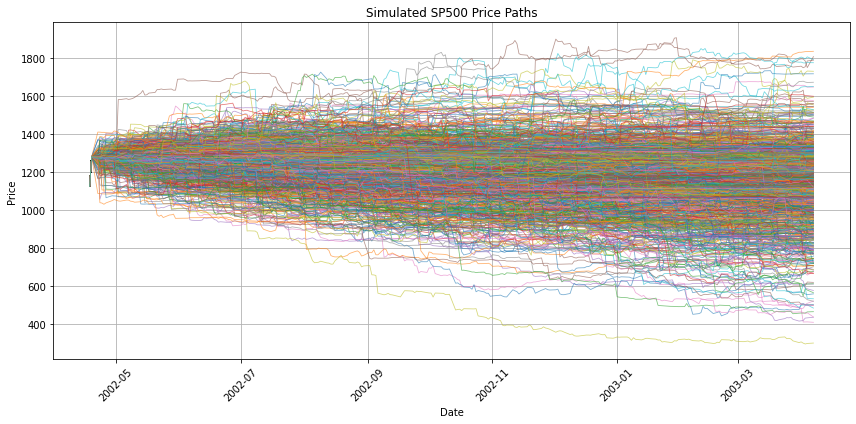

In [27]:
#NIG_CIR Parameters
kappa = 0.5391     # Mean reversion speed
eta = 1.5746       # Long-term mean
lambda_ = 1.8772   # Volatility
y0 = 1     # Initial value
T = 1.0       # Time horizon
N = 252      # Number of time steps
alpha = 18.4815 #Tail heaviness parameter for the NIG process.
beta = -4.8412 #Asymmetry parameter for the NIG process.
delta = 0.4685 #Scale parameter for the NIG process.
starting_price = 1124.47
r = 0.019                                                                                               
q = 0.012
num_paths = 1000  # Number of trajectories
# Set the starting date for the x-axis
start_date = pd.to_datetime("2002-04-18")
dates = pd.date_range(start=start_date, periods=N + 1, freq='B')  # Business days only
# Initialize an array to store paths
paths = np.zeros((N + 1, num_paths))
paths[0] = starting_price  # Set initial price for all paths
u = -1*delta*(math.sqrt(alpha*alpha-(beta+1)**2) - math.sqrt(alpha*alpha-beta*beta)) #New u* for the risk-neutral correction
# Simulate each path
for i in range(num_paths):
    # Generate a new set of daily log returns for this trajectory
    time, levy_process = get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta)
    risk_neutral_ =  risk_neutral (r, q, u, T, kappa, eta, lambda_, y0) 
    prices = starting_price * np.exp(levy_process) * risk_neutral_
    paths[1:, i] = prices  # Convert log returns to price path
# Plot the 100 simulated paths
plt.figure(figsize=(12, 6))
for i in range(num_paths):
    plt.plot(dates, paths[:, i], linewidth=0.8, alpha=0.6)
plt.title("Simulated SP500 Price Paths")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Call options pricing using Montecarlo simulation

### 2.1 Black-Scholes formula (benchmark of theoretical options' prices)

In [5]:
import math
from scipy.stats import norm

def black_scholes_dividend(S, K, T, r, sigma, q, option_type="call"):
    """
    Calculate the Black-Scholes price of a European call or put option on a dividend-paying stock.

    Parameters:
    - S (float): Current stock price
    - K (float): Option strike price
    - T (float): Time to expiration in years
    - r (float): Risk-free interest rate
    - sigma (float): Volatility of the underlying asset
    - q (float): Continuous dividend yield
    - option_type (str): "call" for call option or "put" for put option
    
    Returns:
    - float: Price of the option
    """
    # Calculate d1 and d2
    d1 = (math.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    if option_type == "call":
        # Call option price
        option_price = S * math.exp(-q * T) * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        # Put option price
        option_price = K * math.exp(-r * T) * norm.cdf(-d2) - S * math.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return option_price


#### Test function: price Shoutens' book options

    Strike  Market Price  Black-Scholes Price  Relative Error
0     1025         146.5           137.267441        0.063021
1     1100          96.2            92.393305        0.039571
2     1125          81.7            79.991073        0.020917
3     1150          68.3            68.841036        0.007921
4     1175          56.6            58.898343        0.040607
5     1200          46.1            50.102736        0.086827
6     1225          36.9            42.382039        0.148565
7     1250          29.3            35.655694        0.216918
8     1275          22.5            29.838101        0.326138
9     1300          17.2            24.841644        0.444282
10    1325          12.8            20.579274        0.607756

Average Relative Percentage Error (ARPE): 18.20%


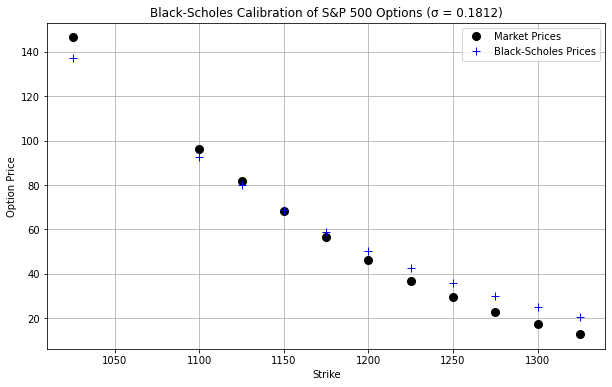

In [12]:
#Consider the call options with maturity March 2003 in page 155 Shoutens's Book
strikes=[1025, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325]
market_prices=[146.50, 96.20, 81.70, 68.30, 56.60, 46.10, 36.90, 29.30, 22.50, 17.20, 12.80]
#Black-Scholes paramters estimated by shoutens
r = 0.019
q = 0.012
S = 1124.47
T = 11/12 #From April 2002 to March 2003
sigma = 0.1812 #page 39
#Compute the ARPE
# Calculate Black-Scholes prices
bs_prices = [black_scholes_dividend(S, K, T, r, sigma, q, option_type="call") for K in strikes]
# Create a DataFrame with strikes, market prices, and Black-Scholes prices
data = {
    'Strike': strikes,
    'Market Price': market_prices,
    'Black-Scholes Price': bs_prices
}
df = pd.DataFrame(data)
# Calculate Average Relative Percentage Error (ARPE)
df['Relative Error'] = abs((df['Market Price'] - df['Black-Scholes Price']) / df['Market Price'])
ARPE = df['Relative Error'].mean() * 100  # Convert to percentage
print(df)
print(f"\nAverage Relative Percentage Error (ARPE): {ARPE:.2f}%")
#Plot similar to Shoutens' book
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Strike'], df['Market Price'], 'o', label='Market Prices', markersize=8, color='black')  # Circles for market prices
plt.plot(df['Strike'], df['Black-Scholes Price'], '+', label='Black-Scholes Prices', markersize=8, color='blue')  # Plus symbols for BS prices
# Labels and title
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.title('Black-Scholes Calibration of S&P 500 Options (σ = 0.1812)')
plt.legend()
plt.grid(True)
plt.show()


### 2.2 Montecarlo simulation using NIG_CIR process

In [34]:
def get_montecarlo_nig_cir_call(kappa, eta, lambda_, y0, T, N, alpha, beta, delta, r, q, u, strike, num_paths):
    u = -1*delta*(math.sqrt(alpha*alpha-(beta+1)**2) - math.sqrt(alpha*alpha-beta*beta)) #New u* for the risk-neutral correction
    payoffs=[]
    # Simulate each path
    for i in range(num_paths):
        # Generate a new set of daily log returns for this trajectory
        time, levy_process = get_NIG_CIR(kappa, eta, lambda_, y0, T, N, alpha, beta, delta)
        risk_neutral_ =  risk_neutral (r, q, u, T, kappa, eta, lambda_, y0) 
        prices = starting_price * np.exp(levy_process) * risk_neutral_
        if prices[-1]>strike:
            payoffs.append(prices[-1]-strike)
        else:
            payoffs.append(0)
    return statistics.mean(payoffs)

#### Test function: price Shoutens' book options

    Strike  Market Price  NIG_CIR Price  Relative Error
0     1025         146.5      77.973984        0.467754
1     1100          96.2      42.067342        0.562710
2     1125          81.7      33.490959        0.590074
3     1150          68.3      27.107791        0.603107
4     1175          56.6      22.648884        0.599843
5     1200          46.1      14.171478        0.692593
6     1225          36.9      12.310087        0.666393
7     1250          29.3       6.342934        0.783518
8     1275          22.5       6.337379        0.718339
9     1300          17.2       3.870918        0.774947
10    1325          12.8       4.256246        0.667481

Average Relative Percentage Error (ARPE): 64.79%


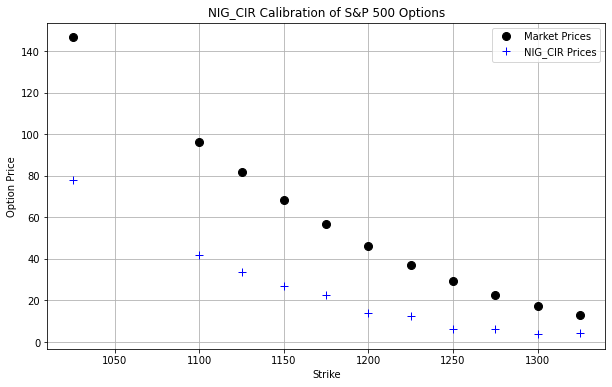

In [36]:
#Consider the call options with maturity March 2003 in page 155 Shoutens's Book
strikes=[1025, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325]
market_prices=[146.50, 96.20, 81.70, 68.30, 56.60, 46.10, 36.90, 29.30, 22.50, 17.20, 12.80]
#NIG_CIR paramters estimated by shoutens
#NIG_CIR Parameters
kappa = 0.5391     # Mean reversion speed
eta = 1.5746       # Long-term mean
lambda_ = 1.8772   # Volatility
y0 = 1     # Initial value
T = 11/12       # Time horizon
N = 231      # Number of time steps
alpha = 18.4815 #Tail heaviness parameter for the NIG process.
beta = -4.8412 #Asymmetry parameter for the NIG process.
delta = 0.4685 #Scale parameter for the NIG process.
starting_price = 1124.47
r = 0.019                                                                                               
q = 0.012
num_paths = 1000  # Number of trajectories
#Compute the ARPE
# Calculate Black-Scholes prices
nig_cir_prices = [get_montecarlo_nig_cir_call(kappa, eta, lambda_, y0, T, N, alpha, beta, delta, r, q, u, K, num_paths) for K in strikes]
# Create a DataFrame with strikes, market prices, and Black-Scholes prices
data = {
    'Strike': strikes,
    'Market Price': market_prices,
    'NIG_CIR Price': nig_cir_prices
}
df = pd.DataFrame(data)
# Calculate Average Relative Percentage Error (ARPE)
df['Relative Error'] = abs((df['Market Price'] - df['NIG_CIR Price']) / df['Market Price'])
ARPE = df['Relative Error'].mean() * 100  # Convert to percentage
print(df)
print(f"\nAverage Relative Percentage Error (ARPE): {ARPE:.2f}%")
#Plot similar to Shoutens' book
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Strike'], df['Market Price'], 'o', label='Market Prices', markersize=8, color='black')  # Circles for market prices
plt.plot(df['Strike'], df['NIG_CIR Price'], '+', label='NIG_CIR Prices', markersize=8, color='blue')  # Plus symbols for BS prices
# Labels and title
plt.xlabel('Strike')
plt.ylabel('Option Price')
plt.title('NIG_CIR Calibration of S&P 500 Options')
plt.legend()
plt.grid(True)
plt.show()


## 3. Exotic option pricing using Montecarlo simulation